# Scaling factor correction
In this notebook you can see how test counts are corrected by the weekly report from Our World in Data (OWID).
We first make the prediction with Prophet and then correct by comparing the predicted test count volume to the summarized report uploaded to OWID.

**Note**: This notebook cannot be executed because the test count data from RKI cannot be uoloaded to git for privacy reasons

In [1]:
# this cell makes it easier to mess with the project code interactively
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import logging
import numpy
import pandas
import pathlib
import matplotlib
from matplotlib import pyplot, cm

import arviz
import pymc3

_log = logging.getLogger('notebook')
logging.basicConfig(level=logging.INFO)

# messing with the path to get imports working
import sys
sys.path.append(str(pathlib.Path("..").resolve()))

import rtlive
from rtlive import data, preprocessing

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


In [3]:
# import of the country submodule adds data loading/preprocessing support
from rtlive.sources import data_de

In [4]:
country_alpha2 = 'DE'
run_date = datetime.datetime.today()
run_date_str = run_date.strftime('%Y-%m-%d')
print(f"Running for {country_alpha2} on {run_date_str}")

Running for DE on 2021-02-03


### Create two DataFrames for testing: One with confirmed test cases for January and one without

In [5]:
# The following file contains the ARCGIS data from January 17 
# and confirmed regional test counts sent by RKI on January 14
df_with_january_tests = pandas.read_csv("2021-01-17 de_all_data.csv", index_col=["region", "date"], parse_dates=["date"])
df_with_december_tests = df_with_january_tests.copy()
# Here we create a DataFrame where we pretend to not have the confirmied daily tests of January
# We therefore overwrite the "new_test" and "positive fraction" columns by a file from January 13
# (On that day we didn't have the confirmed daily tests for January)
df_temp = pandas.read_csv("2021-01-13 de_all_data.csv", index_col=["region", "date"], parse_dates=["date"])
df_with_december_tests[["new_tests", "positive_fraction"]] = numpy.nan
df_with_december_tests["new_tests"] = df_temp.loc[df_temp.index, "new_tests"]
df_with_december_tests["positive_fraction"] = df_temp.loc[df_temp.index, "positive_fraction"]

### Load data from OWID for comparison

In [6]:
df_owid = data_de.get_owid_summarized_totals(run_date)
# Update the artificially generated DataFrame with OWID data
# This is normally done in "get_testcounts_DE"
df_with_december_tests = df_with_december_tests.assign(owid_total_tests=df_owid)

In [7]:
df, results = data_de.forecast_DE(df_with_december_tests.loc[["all"]])

INFO:\\ibt733\repos\rtlive-global-pr\rtlive\preprocessing.py:Forecasting testcount gaps for all from 287 training points.


In [8]:
df.tail(n=30)

new_cases  new_deaths  new_tests  positive_fraction  \
region date                                                              
all    2020-12-17      31450         899        NaN                NaN   
       2020-12-18      29291         787        NaN                NaN   
       2020-12-19      21448         609        NaN                NaN   
       2020-12-20      13703         415        NaN                NaN   
       2020-12-21      20013         645        NaN                NaN   
       2020-12-22      28417         850        NaN                NaN   
       2020-12-23      33290         859        NaN                NaN   
       2020-12-24      20820         486        NaN                NaN   
       2020-12-25      13036         363        NaN                NaN   
       2020-12-26      11400         405        NaN                NaN   
       2020-12-27       9695         321        NaN                NaN   
       2020-12-28      15585         571        NaN                NaN   
       2020-12-29      27002         769        NaN                NaN   
       2020-12-30      30631         720        NaN                NaN   
       2020-12-31      19375         450        NaN                NaN   
       2021-01-01      10185         222        NaN                NaN   
       2021-01-02       9960         279        NaN                NaN   
       2021-01-03       8705         246        NaN                NaN   
       2021-01-04      13978         379        NaN                NaN   
       2021-01-05      26987         438        NaN                NaN   
       2021-01-06      27348         344        NaN                NaN   
       2021-01-07      25556         352        NaN                NaN   
       2021-01-08      23760         239        NaN                NaN   
       2021-01-09      16162         139        NaN                NaN   
       2021-01-10       8341          93        NaN                NaN   
       2021-01-11      13352         119        NaN                NaN   
       2021-01-12      22062         147        NaN                NaN   
       2021-01-13      23465          80        NaN                NaN   
       2021-01-14      19775          73        NaN                NaN   
       2021-01-15      16375          76        NaN                NaN   

                   owid_total_tests  predicted_new_tests_raw scaling_factor  \
region date                                                                   
all    2020-12-17               NaN            102871.487750        2.68457   
       2020-12-18               NaN             98908.973067        2.68457   
       2020-12-19               NaN             27248.103290        2.68457   
       2020-12-20        33142332.0             19187.610148        2.68457   
       2020-12-21               NaN            130084.545986        1.97407   
       2020-12-22               NaN            117414.308804        1.97407   
       2020-12-23               NaN            106623.367837        1.97407   
       2020-12-24               NaN            103268.902293        1.97407   
       2020-12-25               NaN             68952.719783        1.97407   
       2020-12-26               NaN                 0.000000        1.97407   
       2020-12-27        34219398.0             19261.613463        1.97407   
       2020-12-28               NaN            130585.983440        1.40292   
       2020-12-29               NaN            117866.657145        1.40292   
       2020-12-30               NaN            107033.917231        1.40292   
       2020-12-31               NaN            103666.316835        1.40292   
       2021-01-01               NaN             69217.927955        1.40292   
       2021-01-02               NaN             27458.401661        1.40292   
       2021-01-03        35026306.0             19335.616777        1.40292   
       2021-01-04               NaN            131087.420893        1.

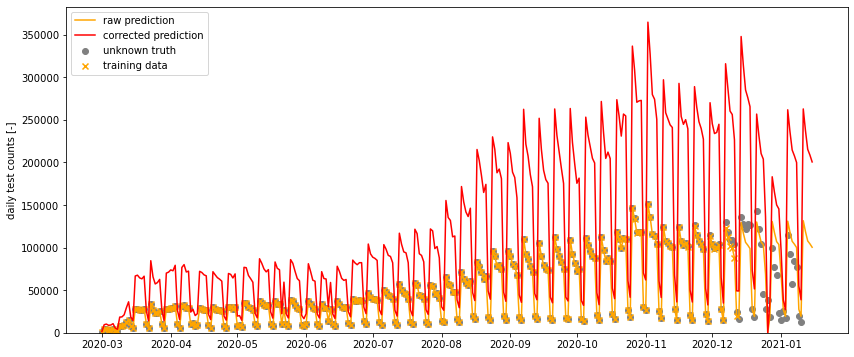

In [9]:
fig, axs = pyplot.subplots(figsize=(14,6))

axs.scatter(
    df_with_january_tests.xs("all").index,
    df_with_january_tests.xs("all").new_tests,
    label="unknown truth",
    marker="o", color="gray",
)
axs.plot(
    df.xs("all").index,
    df.xs("all").predicted_new_tests_raw,
    label="raw prediction",
    color="orange",
)
axs.plot(
    df.xs("all").index,
    df.xs("all").predicted_new_tests,
    label="corrected prediction",
    color="red",
)
axs.scatter(
    df.xs("all").index,
    df.xs("all").new_tests,
    label="training data",
    marker="x", color="orange",
)
axs.legend()
#axs.set_xlim(pandas.Timestamp("2020-11"))
axs.set_ylabel('daily test counts [-]')
axs.set_ylim(0)
pyplot.show()